In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from bokeh.plotting import figure, show
from bokeh.palettes import Spectral4
# from bkcharts import TimeSeries, output_file, show
from bokeh.io import output_notebook
output_notebook()

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Using TensorFlow backend.


Loading BokehJS ...

# Data Preparation

Data yang digunakan untuk pengujian ini dataset delay penerbangan kota New York pada bulan Januari 2019. Data ini awalnya terdapat 16 atribut. **CRS** berarti waktu yang sudah terjadwal, sedangkan **ACTUAL** berarti waktu yang sebenarnya terjadi. *Departure delay* berupa anga dalam satuan menit, bila data > 0 maka terjadi *delay*, bila data = 0 berarti keberangkatan tepat waktu, sedangkan data < 0 (atau negatif) berarti keberangkatan lebih awal.

In [2]:
data = pd.read_csv('dataset.csv')
data = data.drop(['Unnamed: 16'], axis=1)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
0,2019-01-01,12265,"Niagara Falls, NY",14082,"Punta Gorda, FL",1156,1213.0,17.0,1447,1514.0,27.0,0.0,0.0,171.0,181.0,159.0
1,2019-01-01,10257,"Albany, NY",14082,"Punta Gorda, FL",1840,1937.0,57.0,2144,2250.0,66.0,0.0,0.0,184.0,193.0,177.0
2,2019-01-01,14025,"Plattsburgh, NY",11697,"Fort Lauderdale, FL",1329,1320.0,-9.0,1658,1708.0,10.0,0.0,0.0,209.0,228.0,188.0


### Convert FL_DATE to datetime

In [3]:
data['FL_DATE'] = pd.to_datetime(data.FL_DATE)
# data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
# data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')

### Split *CRS departure time* during 00:00 - 00:59

In [4]:
dropindex = []
for i in data.itertuples():
    x = len(str(i.CRS_DEP_TIME))
    if x == 2:
        dropindex.append(i.Index)
data1 = data.loc[dropindex]
data.drop(data.index[dropindex], inplace=True)
data1.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
1498,2019-01-01,12892,"Los Angeles, CA",12478,"New York, NY",38,33.0,-5.0,900,846.0,-14.0,0.0,0.0,322.0,313.0,273.0
1769,2019-01-02,14107,"Phoenix, AZ",12478,"New York, NY",31,57.0,26.0,705,724.0,19.0,0.0,0.0,274.0,267.0,243.0
2393,2019-01-02,12892,"Los Angeles, CA",12478,"New York, NY",38,38.0,0.0,900,853.0,-7.0,0.0,0.0,322.0,315.0,288.0
2894,2019-01-02,11057,"Charlotte, NC",14576,"Rochester, NY",10,1.0,-9.0,156,133.0,-23.0,0.0,0.0,106.0,92.0,72.0
4587,2019-01-03,14107,"Phoenix, AZ",12478,"New York, NY",31,29.0,-2.0,705,659.0,-6.0,0.0,0.0,274.0,270.0,243.0


### Convert *CRS departure time* from int to time

In [5]:
data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
data1['CRS_DEP_TIME'] = pd.to_datetime(data1['CRS_DEP_TIME'], format='%M').dt.time

### Merge *CRS departure time*

In [6]:
data = data.append(data1)
data.sort_index(inplace=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
0,2019-01-01,12265,"Niagara Falls, NY",14082,"Punta Gorda, FL",11:56:00,1213.0,17.0,1447,1514.0,27.0,0.0,0.0,171.0,181.0,159.0
1,2019-01-01,10257,"Albany, NY",14082,"Punta Gorda, FL",18:40:00,1937.0,57.0,2144,2250.0,66.0,0.0,0.0,184.0,193.0,177.0
2,2019-01-01,14025,"Plattsburgh, NY",11697,"Fort Lauderdale, FL",13:29:00,1320.0,-9.0,1658,1708.0,10.0,0.0,0.0,209.0,228.0,188.0
3,2019-01-01,14761,"Sanford, FL",14025,"Plattsburgh, NY",08:15:00,812.0,-3.0,1108,1049.0,-19.0,0.0,0.0,173.0,157.0,142.0
4,2019-01-01,14082,"Punta Gorda, FL",12265,"Niagara Falls, NY",08:30:00,849.0,19.0,1111,1128.0,17.0,0.0,0.0,161.0,159.0,136.0


In [7]:
data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')
data = data.sort_values(by='FL_DATE',ascending=True)
data.reset_index(inplace=True, drop=True)
data.head()
data.loc[data['DEP_TIME'] == 7]

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
1609,2019-01-01 23:59:00,11292,"Denver, CO",12478,"New York, NY",23:59:00,7.0,8.0,535,522.0,-13.0,0.0,0.0,216.0,195.0,173.0
10484,2019-01-06 22:20:00,11278,"Washington, DC",14576,"Rochester, NY",22:20:00,7.0,107.0,2337,110.0,93.0,0.0,0.0,77.0,63.0,53.0
19118,2019-01-10 23:59:00,11292,"Denver, CO",12478,"New York, NY",23:59:00,7.0,8.0,540,544.0,4.0,0.0,0.0,221.0,217.0,187.0
35431,2019-01-18 23:59:00,13891,"Ontario, CA",12478,"New York, NY",23:59:00,7.0,8.0,818,816.0,-2.0,0.0,0.0,319.0,309.0,285.0
46750,2019-01-24 22:05:00,12264,"Washington, DC",12953,"New York, NY",22:05:00,7.0,122.0,2315,104.0,109.0,0.0,0.0,70.0,57.0,43.0
56639,2019-01-29 23:59:00,12478,"New York, NY",10732,"Aguadilla, PR",23:59:00,7.0,8.0,445,452.0,7.0,0.0,0.0,226.0,225.0,196.0
60793,2019-01-31 20:50:00,10792,"Buffalo, NY",12478,"New York, NY",20:50:00,7.0,197.0,2215,123.0,188.0,0.0,0.0,85.0,76.0,54.0


### Check NaN

In [8]:
data.isna().sum()

FL_DATE                   0
ORIGIN_AIRPORT_ID         0
ORIGIN_CITY_NAME          0
DEST_AIRPORT_ID           0
DEST_CITY_NAME            0
CRS_DEP_TIME              0
DEP_TIME               2276
DEP_DELAY              2277
CRS_ARR_TIME              0
ARR_TIME               2389
ARR_DELAY              2520
CANCELLED                 0
DIVERTED                  0
CRS_ELAPSED_TIME          2
ACTUAL_ELAPSED_TIME    2520
AIR_TIME               2520
dtype: int64

### Drop NaN and check again

In [9]:
data = data.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])
data.isna().sum()

FL_DATE                0
ORIGIN_AIRPORT_ID      0
ORIGIN_CITY_NAME       0
DEST_AIRPORT_ID        0
DEST_CITY_NAME         0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
dtype: int64

### Calculate *Departure time* based on *Departure delay*

Because there is some error with value in DEP_DELAY column, so we need to calculate its value to make sure the value is right.

In [10]:
# Example, the value of departure delay is only 1 digit (7) 
# because int dtype cannot display 0 before integer. 
data.loc[1223]

FL_DATE                2019-01-01 17:44:00
ORIGIN_AIRPORT_ID                    12478
ORIGIN_CITY_NAME              New York, NY
DEST_AIRPORT_ID                      14747
DEST_CITY_NAME                 Seattle, WA
CRS_DEP_TIME                      17:44:00
DEP_TIME                              1736
DEP_DELAY                               -8
CRS_ARR_TIME                          2105
ARR_TIME                              2107
ARR_DELAY                                2
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       381
ACTUAL_ELAPSED_TIME                    391
AIR_TIME                               343
Name: 1223, dtype: object

In [11]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.DEP_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.DEP_TIME != k:
        data.at[row.Index, 'DEP_TIME'] = k

In [12]:
data.loc[1609]

FL_DATE                2019-01-01 23:59:00
ORIGIN_AIRPORT_ID                    11292
ORIGIN_CITY_NAME                Denver, CO
DEST_AIRPORT_ID                      12478
DEST_CITY_NAME                New York, NY
CRS_DEP_TIME                      23:59:00
DEP_TIME                    1 day, 0:07:00
DEP_DELAY                                8
CRS_ARR_TIME                           535
ARR_TIME                               522
ARR_DELAY                              -13
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       216
ACTUAL_ELAPSED_TIME                    195
AIR_TIME                               173
Name: 1609, dtype: object

### Delete day on *Departure time*

In [13]:
to_str = []
for row in data.itertuples():
    i = len(str(row.DEP_TIME))
    if i != 8:
        to_str.append(row.Index)

In [14]:
data3 = data.loc[set(data.index) - set(to_str)]
data4 = data.loc[to_str]

data3['DEP_TIME'] = pd.to_datetime(data3['DEP_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data4['DEP_TIME'] = pd.to_datetime(data4['DEP_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [15]:
data4.loc[1609]

FL_DATE                2019-01-01 23:59:00
ORIGIN_AIRPORT_ID                    11292
ORIGIN_CITY_NAME                Denver, CO
DEST_AIRPORT_ID                      12478
DEST_CITY_NAME                New York, NY
CRS_DEP_TIME                      23:59:00
DEP_TIME                          00:07:00
DEP_DELAY                                8
CRS_ARR_TIME                           535
ARR_TIME                               522
ARR_DELAY                              -13
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       216
ACTUAL_ELAPSED_TIME                    195
AIR_TIME                               173
Name: 1609, dtype: object

### Merge

In [16]:
data = data3.append(data4)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
87,2019-01-01 06:20:00,15096,"Syracuse, NY",11697,"Fort Lauderdale, FL",06:20:00,10:25:00,245.0,956,1354.0,238.0,0.0,0.0,216.0,209.0,194.0
296,2019-01-01 08:30:00,12197,"White Plains, NY",14635,"Fort Myers, FL",08:30:00,13:03:00,273.0,1148,1617.0,269.0,0.0,0.0,198.0,194.0,173.0
311,2019-01-01 08:34:00,11298,"Dallas/Fort Worth, TX",12953,"New York, NY",08:34:00,12:47:00,253.0,1256,1650.0,234.0,0.0,0.0,202.0,183.0,158.0


### Calculate CRS Arrival time based on CRS Elapsed time

Because there is some error with value in CRS_ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [17]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.CRS_ELAPSED_TIME
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    d = dt.timedelta(minutes=j)
    k = c + d
    if row.CRS_ARR_TIME != k:
        data.at[row.Index, 'CRS_ARR_TIME'] = k

In [18]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
87,2019-01-01 06:20:00,15096,"Syracuse, NY",11697,"Fort Lauderdale, FL",06:20:00,10:25:00,245.0,9:56:00,1354.0,238.0,0.0,0.0,216.0,209.0,194.0
296,2019-01-01 08:30:00,12197,"White Plains, NY",14635,"Fort Myers, FL",08:30:00,13:03:00,273.0,11:48:00,1617.0,269.0,0.0,0.0,198.0,194.0,173.0
311,2019-01-01 08:34:00,11298,"Dallas/Fort Worth, TX",12953,"New York, NY",08:34:00,12:47:00,253.0,11:56:00,1650.0,234.0,0.0,0.0,202.0,183.0,158.0
327,2019-01-01 08:50:00,12478,"New York, NY",10785,"Burlington, VT",08:50:00,11:22:00,152.0,10:15:00,1227.0,132.0,0.0,0.0,85.0,65.0,45.0
347,2019-01-01 09:00:00,12478,"New York, NY",14771,"San Francisco, CA",09:00:00,10:23:00,83.0,15:52:00,1336.0,44.0,0.0,0.0,412.0,373.0,356.0


In [19]:
to_str = []
for row in data.itertuples():
    i = len(str(row.CRS_ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [20]:
data6 = data.loc[set(data.index) - set(to_str)]
data7 = data.loc[to_str]

data6['CRS_ARR_TIME'] = pd.to_datetime(data6['CRS_ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data7['CRS_ARR_TIME'] = pd.to_datetime(data7['CRS_ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [21]:
data = data6.append(data7)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
24,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,1351.0,-7.0,0.0,0.0,318.0,301.0,270.0
27,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,932.0,23.0,0.0,0.0,384.0,387.0,353.0
33,2019-01-01 06:00:00,10792,"Buffalo, NY",12889,"Las Vegas, NV",06:00:00,05:59:00,-1.0,11:10:00,800.0,-10.0,0.0,0.0,310.0,301.0,287.0
65,2019-01-01 06:05:00,12953,"New York, NY",12191,"Houston, TX",06:05:00,06:38:00,33.0,10:10:00,952.0,42.0,0.0,0.0,245.0,254.0,238.0
66,2019-01-01 06:05:00,12953,"New York, NY",11259,"Dallas, TX",06:05:00,06:40:00,35.0,10:10:00,947.0,37.0,0.0,0.0,245.0,247.0,233.0


### Calculate Arrival time based on Arrival delay

Because there is some error with value in ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [22]:
for row in data.itertuples():
    i = row.CRS_ARR_TIME
    j = row.ARR_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.ARR_TIME != k:
        data.at[row.Index, 'ARR_TIME'] = k

In [23]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
24,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0
27,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0
33,2019-01-01 06:00:00,10792,"Buffalo, NY",12889,"Las Vegas, NV",06:00:00,05:59:00,-1.0,11:10:00,11:00:00,-10.0,0.0,0.0,310.0,301.0,287.0
65,2019-01-01 06:05:00,12953,"New York, NY",12191,"Houston, TX",06:05:00,06:38:00,33.0,10:10:00,10:52:00,42.0,0.0,0.0,245.0,254.0,238.0
66,2019-01-01 06:05:00,12953,"New York, NY",11259,"Dallas, TX",06:05:00,06:40:00,35.0,10:10:00,10:47:00,37.0,0.0,0.0,245.0,247.0,233.0


In [24]:
to_str = []
for row in data.itertuples():
    i = len(str(row.ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [25]:
data8 = data.loc[set(data.index) - set(to_str)]
data9 = data.loc[to_str]

data8['ARR_TIME'] = pd.to_datetime(data8['ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data9['ARR_TIME'] = pd.to_datetime(data9['ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [26]:
data = data8.append(data9)
data.reset_index(inplace=True, drop=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
0,2019-01-01 05:30:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:30:00,05:33:00,3.0,09:45:00,10:25:00,40.0,0.0,0.0,255.0,292.0,234.0
1,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0
2,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0
3,2019-01-01 06:00:00,10792,"Buffalo, NY",12889,"Las Vegas, NV",06:00:00,05:59:00,-1.0,11:10:00,11:00:00,-10.0,0.0,0.0,310.0,301.0,287.0
4,2019-01-01 06:00:00,12478,"New York, NY",11697,"Fort Lauderdale, FL",06:00:00,07:15:00,75.0,09:07:00,10:25:00,78.0,0.0,0.0,187.0,190.0,158.0


### Working Day or not

In [27]:
data["DAY_TYPE"] = data.FL_DATE.apply(lambda x: 1 if x.dayofweek > 5 else 0)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DAY_TYPE
0,2019-01-01 05:30:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:30:00,05:33:00,3.0,09:45:00,10:25:00,40.0,0.0,0.0,255.0,292.0,234.0,0
1,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0,0
2,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0,0


### Finding Federal Holidays

In [28]:
cal = calendar()
holidays = cal.holidays(start = data.FL_DATE.min(), end = data.FL_DATE.max())
data["IS_HOLIDAY"] = data.FL_DATE.isin(holidays)
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DAY_TYPE,IS_HOLIDAY
0,2019-01-01 05:30:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:30:00,05:33:00,3.0,09:45:00,10:25:00,40.0,0.0,0.0,255.0,292.0,234.0,0,False
1,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0,0,False
2,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0,0,False
3,2019-01-01 06:00:00,10792,"Buffalo, NY",12889,"Las Vegas, NV",06:00:00,05:59:00,-1.0,11:10:00,11:00:00,-10.0,0.0,0.0,310.0,301.0,287.0,0,False
4,2019-01-01 06:00:00,12478,"New York, NY",11697,"Fort Lauderdale, FL",06:00:00,07:15:00,75.0,09:07:00,10:25:00,78.0,0.0,0.0,187.0,190.0,158.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58416,2019-01-31 08:45:00,12953,"New York, NY",14100,"Philadelphia, PA",08:45:00,08:45:00,0.0,09:53:00,09:41:00,-12.0,0.0,0.0,68.0,56.0,35.0,0,False
58417,2019-01-31 22:25:00,11433,"Detroit, MI",15096,"Syracuse, NY",22:25:00,00:59:00,154.0,00:01:00,02:26:00,145.0,0.0,0.0,96.0,87.0,53.0,0,False
58418,2019-01-31 22:55:00,12478,"New York, NY",10721,"Boston, MA",22:55:00,00:16:00,81.0,00:02:00,01:24:00,82.0,0.0,0.0,67.0,68.0,39.0,0,False
58419,2019-01-31 23:59:00,12478,"New York, NY",10732,"Aguadilla, PR",23:59:00,00:34:00,35.0,03:45:00,04:11:00,26.0,0.0,0.0,226.0,217.0,195.0,0,False


### Departure from NY or Arrival to NY

In [29]:
data['DEP_FROM_NY'] = data.ORIGIN_CITY_NAME.apply(lambda x: 1 if x[-2:] == 'NY' else 0)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY
0,2019-01-01 05:30:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:30:00,05:33:00,3.0,09:45:00,10:25:00,40.0,0.0,0.0,255.0,292.0,234.0,0,False,1
1,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0,0,False,0
2,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0,0,False,1
3,2019-01-01 06:00:00,10792,"Buffalo, NY",12889,"Las Vegas, NV",06:00:00,05:59:00,-1.0,11:10:00,11:00:00,-10.0,0.0,0.0,310.0,301.0,287.0,0,False,1
4,2019-01-01 06:00:00,12478,"New York, NY",11697,"Fort Lauderdale, FL",06:00:00,07:15:00,75.0,09:07:00,10:25:00,78.0,0.0,0.0,187.0,190.0,158.0,0,False,1
5,2019-01-01 06:00:00,13198,"Kansas City, MO",12953,"New York, NY",06:00:00,08:06:00,126.0,08:45:00,10:42:00,117.0,0.0,0.0,165.0,156.0,122.0,0,False,0
6,2019-01-01 06:05:00,12953,"New York, NY",12191,"Houston, TX",06:05:00,06:38:00,33.0,10:10:00,10:52:00,42.0,0.0,0.0,245.0,254.0,238.0,0,False,1
7,2019-01-01 06:05:00,12953,"New York, NY",11259,"Dallas, TX",06:05:00,06:40:00,35.0,10:10:00,10:47:00,37.0,0.0,0.0,245.0,247.0,233.0,0,False,1
8,2019-01-01 06:05:00,10732,"Aguadilla, PR",12478,"New York, NY",06:05:00,05:51:00,-14.0,09:59:00,10:06:00,7.0,0.0,0.0,234.0,255.0,218.0,0,False,0
9,2019-01-01 06:15:00,12892,"Los Angeles, CA",12478,"New York, NY",06:15:00,06:24:00,9.0,11:32:00,11:08:00,-24.0,0.0,0.0,317.0,284.0,265.0,0,False,0


### Previous Five Observations

In [30]:
for obs in range(1,6):
    data["T_" + str(obs)] = data.DEP_DELAY.shift(obs)

In [31]:
data.fillna(0.00,inplace=True)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
0,2019-01-01 05:30:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:30:00,05:33:00,3.0,09:45:00,10:25:00,40.0,0.0,0.0,255.0,292.0,234.0,0,False,1,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0,0,False,0,3.0,0.0,0.0,0.0,0.0
2,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0,0,False,1,10.0,3.0,0.0,0.0,0.0
3,2019-01-01 06:00:00,10792,"Buffalo, NY",12889,"Las Vegas, NV",06:00:00,05:59:00,-1.0,11:10:00,11:00:00,-10.0,0.0,0.0,310.0,301.0,287.0,0,False,1,20.0,10.0,3.0,0.0,0.0
4,2019-01-01 06:00:00,12478,"New York, NY",11697,"Fort Lauderdale, FL",06:00:00,07:15:00,75.0,09:07:00,10:25:00,78.0,0.0,0.0,187.0,190.0,158.0,0,False,1,-1.0,20.0,10.0,3.0,0.0
5,2019-01-01 06:00:00,13198,"Kansas City, MO",12953,"New York, NY",06:00:00,08:06:00,126.0,08:45:00,10:42:00,117.0,0.0,0.0,165.0,156.0,122.0,0,False,0,75.0,-1.0,20.0,10.0,3.0
6,2019-01-01 06:05:00,12953,"New York, NY",12191,"Houston, TX",06:05:00,06:38:00,33.0,10:10:00,10:52:00,42.0,0.0,0.0,245.0,254.0,238.0,0,False,1,126.0,75.0,-1.0,20.0,10.0
7,2019-01-01 06:05:00,12953,"New York, NY",11259,"Dallas, TX",06:05:00,06:40:00,35.0,10:10:00,10:47:00,37.0,0.0,0.0,245.0,247.0,233.0,0,False,1,33.0,126.0,75.0,-1.0,20.0
8,2019-01-01 06:05:00,10732,"Aguadilla, PR",12478,"New York, NY",06:05:00,05:51:00,-14.0,09:59:00,10:06:00,7.0,0.0,0.0,234.0,255.0,218.0,0,False,0,35.0,33.0,126.0,75.0,-1.0
9,2019-01-01 06:15:00,12892,"Los Angeles, CA",12478,"New York, NY",06:15:00,06:24:00,9.0,11:32:00,11:08:00,-24.0,0.0,0.0,317.0,284.0,265.0,0,False,0,-14.0,35.0,33.0,126.0,75.0


### Change IS_HOLIDAY to integer

In [32]:
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")
# 1 = true, 0 = false
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
0,2019-01-01 05:30:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:30:00,05:33:00,3.0,09:45:00,10:25:00,40.0,0.0,0.0,255.0,292.0,234.0,0,0,1,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 05:40:00,12892,"Los Angeles, CA",12478,"New York, NY",05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0,0,0,0,3.0,0.0,0.0,0.0,0.0
2,2019-01-01 05:45:00,12478,"New York, NY",12892,"Los Angeles, CA",05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0,0,0,1,10.0,3.0,0.0,0.0,0.0
3,2019-01-01 06:00:00,10792,"Buffalo, NY",12889,"Las Vegas, NV",06:00:00,05:59:00,-1.0,11:10:00,11:00:00,-10.0,0.0,0.0,310.0,301.0,287.0,0,0,1,20.0,10.0,3.0,0.0,0.0
4,2019-01-01 06:00:00,12478,"New York, NY",11697,"Fort Lauderdale, FL",06:00:00,07:15:00,75.0,09:07:00,10:25:00,78.0,0.0,0.0,187.0,190.0,158.0,0,0,1,-1.0,20.0,10.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58416,2019-01-31 08:45:00,12953,"New York, NY",14100,"Philadelphia, PA",08:45:00,08:45:00,0.0,09:53:00,09:41:00,-12.0,0.0,0.0,68.0,56.0,35.0,0,0,1,-5.0,6.0,-4.0,-7.0,1.0
58417,2019-01-31 22:25:00,11433,"Detroit, MI",15096,"Syracuse, NY",22:25:00,00:59:00,154.0,00:01:00,02:26:00,145.0,0.0,0.0,96.0,87.0,53.0,0,0,0,0.0,-5.0,6.0,-4.0,-7.0
58418,2019-01-31 22:55:00,12478,"New York, NY",10721,"Boston, MA",22:55:00,00:16:00,81.0,00:02:00,01:24:00,82.0,0.0,0.0,67.0,68.0,39.0,0,0,1,154.0,0.0,-5.0,6.0,-4.0
58419,2019-01-31 23:59:00,12478,"New York, NY",10732,"Aguadilla, PR",23:59:00,00:34:00,35.0,03:45:00,04:11:00,26.0,0.0,0.0,226.0,217.0,195.0,0,0,1,81.0,154.0,0.0,-5.0,6.0


In [33]:
data.columns

Index(['FL_DATE', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DAY_TYPE',
       'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5'],
      dtype='object')

In [34]:
le = LabelEncoder()
normal_data = data
normal_data['ORIGIN_CITY_NAME'] = le.fit_transform(normal_data['ORIGIN_CITY_NAME'])
normal_data['DEST_CITY_NAME'] = le.fit_transform(normal_data['DEST_CITY_NAME'])
normal_data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
0,2019-01-01 05:30:00,12953,63,11298,25,05:30:00,05:33:00,3.0,09:45:00,10:25:00,40.0,0.0,0.0,255.0,292.0,234.0,0,0,1,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 05:40:00,12892,51,12478,63,05:40:00,05:50:00,10.0,10:58:00,10:51:00,-7.0,0.0,0.0,318.0,301.0,270.0,0,0,0,3.0,0.0,0.0,0.0,0.0
2,2019-01-01 05:45:00,12478,63,12892,51,05:45:00,06:05:00,20.0,12:09:00,12:32:00,23.0,0.0,0.0,384.0,387.0,353.0,0,0,1,10.0,3.0,0.0,0.0,0.0
3,2019-01-01 06:00:00,10792,11,12889,48,06:00:00,05:59:00,-1.0,11:10:00,11:00:00,-10.0,0.0,0.0,310.0,301.0,287.0,0,0,1,20.0,10.0,3.0,0.0,0.0
4,2019-01-01 06:00:00,12478,63,11697,34,06:00:00,07:15:00,75.0,09:07:00,10:25:00,78.0,0.0,0.0,187.0,190.0,158.0,0,0,1,-1.0,20.0,10.0,3.0,0.0


### Clean Data

In [35]:
clean_data = data[['FL_DATE', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 
                   'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 
                   'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 
                   'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_data['FL_DATE'].loc[30:]

30      2019-01-01 07:00:00
31      2019-01-01 07:00:00
32      2019-01-01 07:00:00
33      2019-01-01 07:00:00
34      2019-01-01 07:00:00
                ...        
58416   2019-01-31 08:45:00
58417   2019-01-31 22:25:00
58418   2019-01-31 22:55:00
58419   2019-01-31 23:59:00
58420   2019-01-31 23:59:00
Name: FL_DATE, Length: 58391, dtype: datetime64[ns]

### Train and test data

In [36]:
training_data = data[data.FL_DATE < pd.to_datetime('2019-01-24')]

In [37]:
val_mask = (data.FL_DATE >= pd.to_datetime('2019-01-24')) & (data.FL_DATE < pd.to_datetime('2019-01-25'))
val_data = data.loc[val_mask]

In [38]:
test_data = data[data.FL_DATE >= pd.to_datetime('2019-01-25')]

In [39]:
clean_train = training_data[['CRS_ELAPSED_TIME',
                             'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 
                             'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_test = test_data[['CRS_ELAPSED_TIME',
                             'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 
                             'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_val = val_data[['CRS_ELAPSED_TIME',
                             'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 
                             'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]

In [40]:
clean_train.head(3)

,CRS_ELAPSED_TIME,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
0,255.0,0,0,1,0.0,0.0,0.0,0.0,0.0,3.0
1,318.0,0,0,0,3.0,0.0,0.0,0.0,0.0,10.0
2,384.0,0,0,1,10.0,3.0,0.0,0.0,0.0,20.0


In [41]:
clean_test.head(3)

,CRS_ELAPSED_TIME,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
35952,130.0,0,0,1,9.0,20.0,-1.0,11.0,22.0,180.0
35953,318.0,0,0,0,180.0,9.0,20.0,-1.0,11.0,-7.0
35954,384.0,0,0,1,-7.0,180.0,9.0,20.0,-1.0,-10.0


In [42]:
clean_val.head(3)

,CRS_ELAPSED_TIME,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
34504,105.0,0,0,0,-8.0,-8.0,-3.0,8.0,-3.0,263.0
34505,384.0,0,0,1,263.0,-8.0,-8.0,-3.0,8.0,-4.0
34506,318.0,0,0,0,-4.0,263.0,-8.0,-8.0,-3.0,14.0


In [43]:
clean_train.shape

(43202, 10)

In [44]:
data.to_csv('clean.csv')

In [45]:
X_train,y_train = clean_train.drop(["DEP_DELAY"],axis=1),clean_train.DEP_DELAY
X_test,y_test = clean_test.drop(["DEP_DELAY"],axis=1),clean_test.DEP_DELAY
X_val,y_val = clean_val.drop(["DEP_DELAY"],axis=1),clean_val.DEP_DELAY

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_valid_scaled = scaler.fit_transform(X_val)

In [47]:
X_train_scaled

array([[0.30864198, 0.        , 0.        , ..., 0.02529866, 0.02529866,
        0.02529866],
       [0.4058642 , 0.        , 0.        , ..., 0.02529866, 0.02529866,
        0.02529866],
       [0.50771605, 0.        , 0.        , ..., 0.02529866, 0.02529866,
        0.02529866],
       ...,
       [0.39814815, 0.        , 0.        , ..., 0.02319044, 0.01967674,
        0.01967674],
       [0.26388889, 0.        , 0.        , ..., 0.0224877 , 0.02319044,
        0.01967674],
       [0.31481481, 0.        , 0.        , ..., 0.0983837 , 0.0224877 ,
        0.02319044]])

In [48]:
model = Sequential()
model.add(LSTM(300, input_shape=(1, 9)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [49]:
X_t_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [50]:
X_val_resaped = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

In [51]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [52]:
history = model.fit(X_t_reshaped, y_train, validation_data=(X_val_resaped, y_val), 
                    epochs=20, batch_size=96, verbose=2, shuffle=False)
# istory = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 43202 samples, validate on 1940 samples
Epoch 1/20
 - 6s - loss: 20.8251 - val_loss: 75.6197
Epoch 2/20
 - 4s - loss: 20.7311 - val_loss: 75.5830
Epoch 3/20
 - 4s - loss: 20.6928 - val_loss: 75.4286
Epoch 4/20
 - 4s - loss: 20.6509 - val_loss: 75.1793
Epoch 5/20
 - 4s - loss: 20.5997 - val_loss: 74.6588
Epoch 6/20
 - 4s - loss: 20.5340 - val_loss: 73.8636
Epoch 7/20
 - 4s - loss: 20.4591 - val_loss: 72.7086
Epoch 8/20
 - 4s - loss: 20.3773 - val_loss: 71.3736
Epoch 9/20
 - 4s - loss: 20.3027 - val_loss: 70.0966
Epoch 10/20
 - 4s - loss: 20.2467 - val_loss: 69.0755
Epoch 11/20
 - 4s - loss: 20.2080 - val_loss: 68.2705
Epoch 12/20
 - 4s - loss: 20.1801 - val_loss: 67.6221
Epoch 13/20
 - 4s - loss: 20.1573 - val_loss: 67.1213
Epoch 14/20
 - 4s - loss: 20.1422 - val_loss: 66.7709
Epoch 15/20
 - 4s - loss: 20.1284 - val_loss: 66.4682
Epoch 16/20
 - 4s - loss: 20.1138 - val_loss: 66.1950
Epoch 17/20
 - 4s - loss: 20.1003 - val_loss: 65.9352
Epoch 18/20
 - 4s - loss: 20.0880 - val_lo

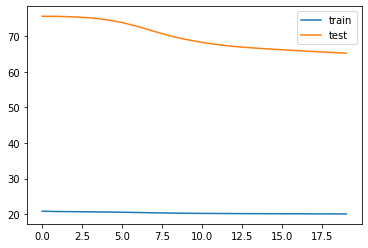

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [54]:
res = model.predict(X_te_reshaped)

In [55]:
test_data["DL_PRED"] = res

In [56]:
np.sqrt(mean_squared_error(test_data.DEP_DELAY,test_data.DL_PRED))

58.62260934681429

In [57]:
# keras_show = TimeSeries(test_data,x="FL_DATE",y=["DEP_DELAY","DL_PRED"],legend=True,plot_width=900, plot_height=350)
# show(keras_show)
sep_30m = test_data[test_data.FL_DATE >= pd.to_datetime("2019-01-31")]
sep_30m.shape

(1999, 25)

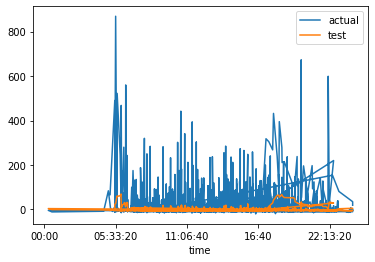

In [58]:
plt.plot(sep_30m['CRS_DEP_TIME'], sep_30m['DEP_DELAY'], label='actual')
plt.plot(sep_30m['CRS_DEP_TIME'], sep_30m['DL_PRED'], label='test')
plt.legend()

In [59]:
p = figure(plot_width=950, plot_height=400, x_axis_type="datetime")

# add a line renderer
p.multi_line([sep_30m['FL_DATE'], sep_30m['FL_DATE']], [sep_30m['DL_PRED'], sep_30m['DEP_DELAY']], 
             color=["blue", "firebrick"], alpha=[0.8, 0.3], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DL_PRED'], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DEP_DELAY'], line_width=2, color='red', legend_label='actual')
p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)